# Día 4: Práctica ARIMA (Parte 1)


Pasos:
- Carga y exploración de los datos.
- Visualizaciones iniciales (plots).
- Verificación de estacionariedad (test ADF, plots).
- Diferenciación si es necesario.
- Cálculo de ACF/PACF y sugerencia de p, d, q.
- Ajuste de ARIMA con statsmodels.
- Análisis de residuos.
- (Opcional) Forecast y visualización final.

# Notebook Día 4: ARIMA (Parte 1) con Dataset Real

**Objetivo**:  

- Aplicar el modelo ARIMA a un dataset de pasajeros mensuales de aerolíneas (AirPassengers).  
- Verificar estacionariedad, diferenciar la serie si es necesario, y usar ACF/PACF y criterios AIC/BIC para encontrar parámetros (p, d, q).  
- Ajustar el modelo y analizar residuales.

---


In [1]:
# Sección 0: Importaciones y Configuración

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline
sns.set_style("whitegrid")

print("Entorno listo para la práctica de ARIMA - Clase 4.")



Entorno listo para la práctica de ARIMA - Clase 4.


## Sección 1: Carga o Creación de Datos

El dataset **AirPassengers** es un clásico en el análisis de series temporales. Contiene el número de pasajeros mensualmente entre 1949 y 1960. Usaremos la versión incluida en `statsmodels`, podemos usar datos sintéticos para este ejemplo.


In [2]:
# Sección 1: Carga del dataset AirPassengers
# statsmodels tiene un dataset similar; también hay versiones en Kaggle.

from statsmodels.datasets import get_rdataset

# 'AirPassengers' está disponible en un R dataset popular, lo cargaremos a través de la API 'get_rdataset'
# Sin embargo, en statsmodels a veces se llama differently. Alternativamente,
# se puede descargar manualmente un CSV si lo tienes.

try:
    dta = get_rdataset('AirPassengers')
    df_air = dta.data
    # A veces el dataset se llama 'value' o 'AirPassengers', verifica su contenido:
    df_air.head()
except:
    print("No se pudo cargar AirPassengers vía get_rdataset. Generaremos un CSV sintético.")
    # Fallback: dataset sintético
    rng = pd.date_range("1949-01", freq="M", periods=144)
    np.random.seed(42)
    base = 100 + np.arange(144)*0.5
    season = 10 * np.sin(2*np.pi*np.arange(144)/12)
    noise = np.random.normal(0,5,144)
    passengers = base + season + noise
    df_air = pd.DataFrame({'time': rng, 'AirPassengers': passengers})
    
df_air.head()


,time,value
0,1949.000000,112
1,1949.083333,118
2,1949.166667,132
3,1949.250000,129
4,1949.333333,121


Observamos las primeras filas para entender la estructura. A veces, el dataset trae nombres de columnas diferentes: "time", "value", etc. Asegurémonos de renombrar si hace falta.

In [10]:
# Ajustamos el DataFrame
if 'time' in df_air.columns:
    df_air = df_air.rename(columns={'time': 'Date'})
if 'AirPassengers' not in df_air.columns and 'value' in df_air.columns:
    df_air = df_air.rename(columns={'value': 'AirPassengers'})

# 1) Renombrar:
df_air = df_air.rename(columns={'time': 'raw_time', 'value': 'AirPassengers'})

# 2) Convertir 'raw_time' en un datetime real
#    Este step es más complicado, ya que 1949.00, 1949.08 no son fechas directas.
#    Podríamos parsear manualmente, o usar un dataset CSV con "Year,Month" en col.

# O simplemente definimos un índice que sea la fila 0 = 1949-01, 1 = 1949-02, etc.
# Ejemplo:
start_year = 1949
start_month = 1
date_range = pd.date_range(start=f"{start_year}-{start_month}-01", periods=len(df_air), freq='ME')

# Asignamos la fecha como nueva columna:
df_air['Date'] = date_range
df_air.set_index('Date', inplace=True)

df_air.head()

,AirPassengers
Date,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121



---
## Sección 2: Visualización y Test de Estacionariedad

Antes de aplicar ARIMA, veamos el gráfico y hagamos una prueba de Dickey-Fuller para ver si la serie es estacionaria.


In [11]:
print("Dimensiones del dataset:", df_air.shape)
df_air.describe()


Dimensiones del dataset: (144, 1)


,AirPassengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


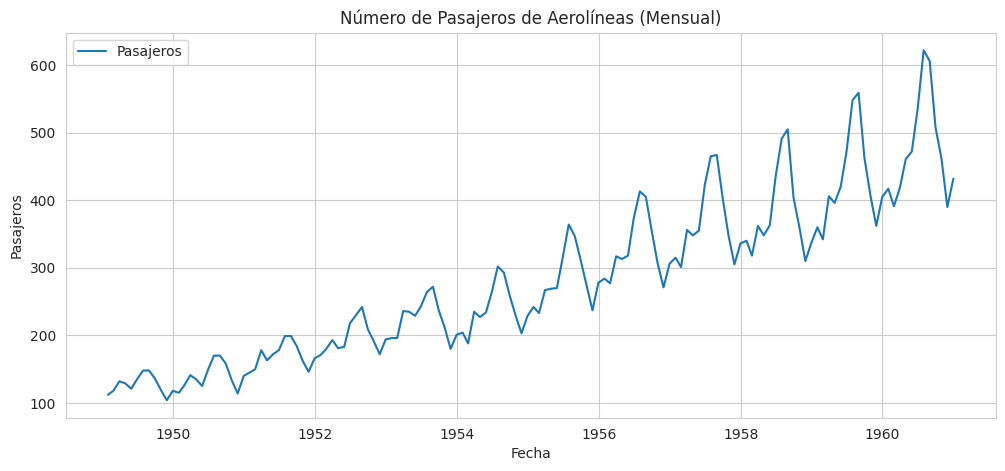

In [12]:
# Plot de la serie
plt.figure(figsize=(12,5))
plt.plot(df_air.index, df_air['AirPassengers'], label='Pasajeros')
plt.title('Número de Pasajeros de Aerolíneas (Mensual)')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.legend()
plt.show()

In [13]:
# Prueba de Dickey-Fuller Aumentado
adf_result = adfuller(df_air['AirPassengers'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: 0.8153688792060539
p-value: 0.9918802434376411


Observamos que la serie parece tener **tendencia creciente** y probable **estacionalidad** (picos cada año).

---

## Sección 3: Verificación de Estacionariedad

La serie muestra tendencia creciente. Usaremos la prueba ADF (Dickey-Fuller Aumentado) para comprobar si es estacionaria o no.


In [15]:
# Sección 3: Test ADF
def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic','p-value','# Lags Used','Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out['Critical Value (%s)'%key] = val
    return out

adf_result = adf_test(df_air['AirPassengers'])
print("Test ADF (AirPassengers):\n", adf_result)


Test ADF (AirPassengers):
 ADF Statistic                    0.815369
p-value                          0.991880
# Lags Used                     13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


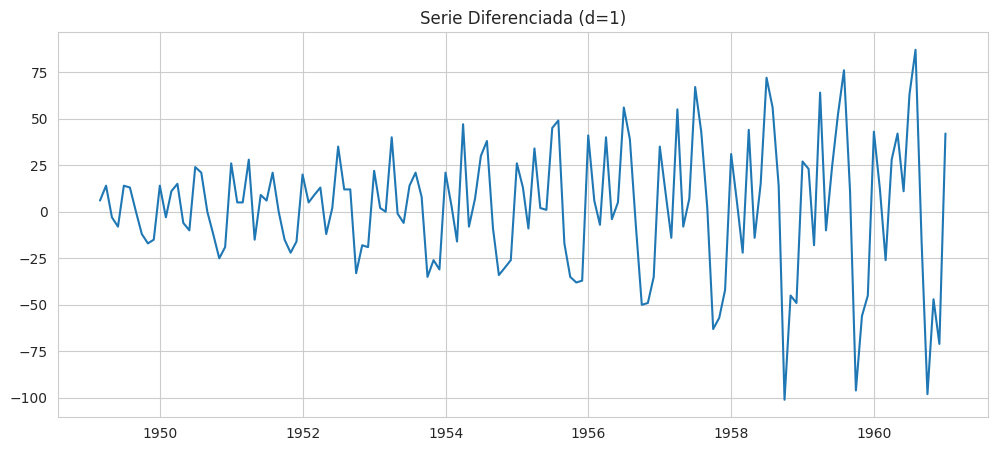

ADF Statistic (Diff1): -2.829266824169995
p-value (Diff1): 0.05421329028382612


In [17]:
df_air['AirPassengers_diff'] = df_air['AirPassengers'].diff()
df_air.dropna(inplace=True)

plt.figure(figsize=(12,5))
plt.plot(df_air.index, df_air['AirPassengers_diff'])
plt.title('Serie Diferenciada (d=1)')
plt.show()

adf_result_diff = adfuller(df_air['AirPassengers_diff'])
print("ADF Statistic (Diff1):", adf_result_diff[0])
print("p-value (Diff1):", adf_result_diff[1])


Si el p-value es **alto** (> 0.05), no rechazamos la hipótesis de no estacionariedad.  
Dado que se observa tendencia, seguramente la serie **no** es estacionaria.

---
## Sección 4: Diferenciación para Lograr Estacionariedad

Dado que la serie es a menudo un recuento con tendencia, es común aplicar una transformación logarítmica antes de diferenciar.


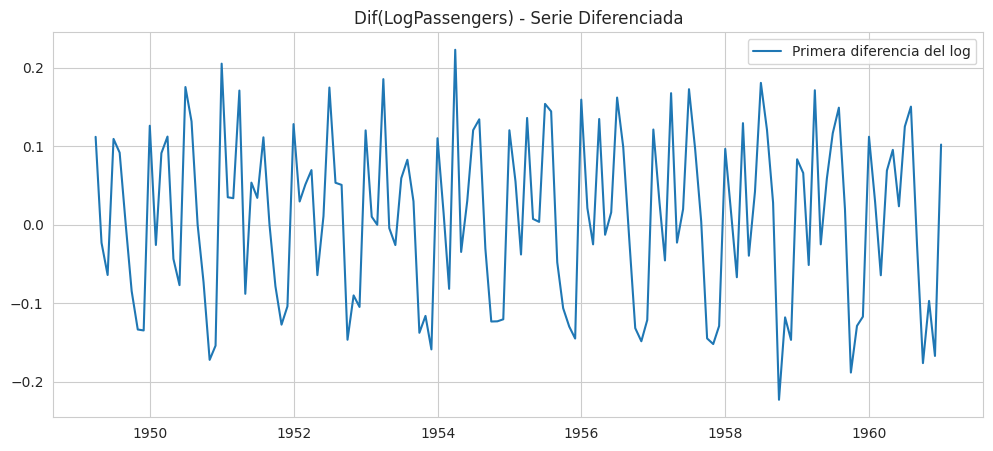

ADF tras diferenciar log:
 ADF Statistic                   -2.877449
p-value                          0.048034
# Lags Used                     14.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


In [19]:
df_air['LogPassengers'] = np.log(df_air['AirPassengers'])

# Primera diferencia
df_air['Diff_LogPassengers'] = df_air['LogPassengers'].diff()

# Plot de la serie diferenciada
plt.figure(figsize=(12,5))
plt.plot(df_air.index, df_air['Diff_LogPassengers'], label='Primera diferencia del log')
plt.title("Dif(LogPassengers) - Serie Diferenciada")
plt.legend()
plt.show()

# Test ADF de la serie diferenciada
adf_diff = adf_test(df_air['Diff_LogPassengers'].dropna())
print("ADF tras diferenciar log:\n", adf_diff)


Observa si el **p-value** disminuye (< 0.05), indicando que la serie ya es estacionaria.

---

## Sección 5: ACF y PACF para Seleccionar p y q

Usaremos la columna `Diff_LogPassengers` (o la original si no hubiéramos tomado log) para calcular ACF y PACF, excluyendo los NaN iniciales.


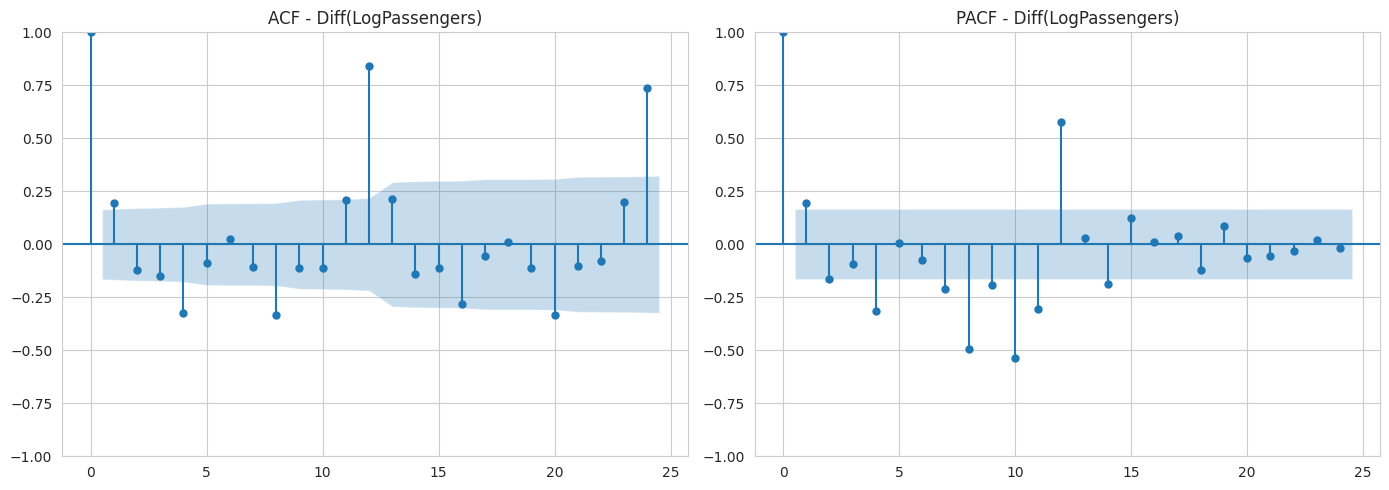

In [21]:
series_diff = df_air['Diff_LogPassengers'].dropna()

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plot_acf(series_diff, lags=24, ax=plt.gca(), title="ACF - Diff(LogPassengers)")

plt.subplot(1,2,2)
plot_pacf(series_diff, lags=24, ax=plt.gca(), title="PACF - Diff(LogPassengers)", method='ywm')
plt.tight_layout()
plt.show()


**Interpretación**:  
- Fíjate dónde la **ACF** se vuelve no significativa → sugiere un valor para q.  
- Fíjate dónde la **PACF** se corta → sugiere p.  
Por ejemplo, si ACF cae bruscamente tras lag=1, q=1. Si PACF tiene un pico grande en lag=1, p=1.

Dado que hicimos una primera diferenciación, d=1.  
Podemos intentar (p, d, q) = (1, 1, 1) como inicio.

---

## Sección 6: Ajuste de un ARIMA

Usaremos `statsmodels.tsa.arima.model.ARIMA` para ajustar un ARIMA sobre la **serie logarítmica** (que es más estable).  


In [22]:
import warnings
warnings.filterwarnings('ignore')  # Para no mostrar warnings de statsmodels

# Definimos la serie a modelar: LogPassengers (no la serie ya diferenciada, statsmodels internamente hace dif)
endog_series = df_air['LogPassengers'].dropna()

# Ajustamos con un primer guess: (p,d,q) = (1,1,1)
from statsmodels.tsa.arima.model import ARIMA

model_111 = ARIMA(endog_series, order=(1,1,1))
results_111 = model_111.fit()
print(results_111.summary())


                               SARIMAX Results                                
Dep. Variable:          LogPassengers   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 123.085
Date:                Wed, 05 Feb 2025   AIC                           -240.171
Time:                        14:04:51   BIC                           -231.303
Sample:                    02-28-1949   HQIC                          -236.567
                         - 12-31-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5885      0.162     -3.640      0.000      -0.905      -0.272
ma.L1          0.8568      0.095      9.008      0.000       0.670       1.043
sigma2         0.0103      0.002      5.947      0.0

Observamos el AIC, BIC y parámetros. Después podemos **probar** otros valores (2,1,1), (1,1,2), etc., comparando AIC/BIC.

---

## Sección 7: Comparación de Varios Modelos

Podríamos hacer un pequeño bucle para comparar AIC de distintos (p,q) manteniendo d=1.


In [23]:
aic_values = {}
for p in range(0,3):
    for q in range(0,3):
        try:
            model = ARIMA(endog_series, order=(p,1,q))
            res = model.fit()
            aic_values[(p,1,q)] = res.aic
        except:
            aic_values[(p,1,q)] = np.nan

aic_values_sorted = sorted(aic_values.items(), key=lambda x: x[1])
print("Modelos ordenados por AIC:")
for k,v in aic_values_sorted:
    print(k, "AIC=", v)


Modelos ordenados por AIC:
(2, 1, 1) AIC= -248.7727439786646
(1, 1, 2) AIC= -246.22443597693638
(2, 1, 2) AIC= -245.36103309296166
(1, 1, 1) AIC= -240.17081591604057
(0, 1, 2) AIC= -238.26523622798499
(0, 1, 1) AIC= -236.0731984235423
(2, 1, 0) AIC= -235.85778616067316
(1, 1, 0) AIC= -233.99677286826952
(0, 1, 0) AIC= -230.0413301267228


El orden que aparezca con el AIC más bajo suele ser **mejor**.  
Podrías quedarte con el de menor AIC e interpretarlo.

---

## Sección 8: Análisis de Residuos

Tomemos el modelo con mejor AIC y analicemos los residuos. Suponiendo (1,1,1) fue el mejor.


Mejor modelo según AIC: (2, 1, 1)
                               SARIMAX Results                                
Dep. Variable:          LogPassengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 128.386
Date:                Wed, 05 Feb 2025   AIC                           -248.773
Time:                        14:05:51   BIC                           -236.949
Sample:                    02-28-1949   HQIC                          -243.968
                         - 12-31-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9773      0.100      9.765      0.000       0.781       1.173
ar.L2         -0.3720      0.118     -3.142      0.002      -0.604      -0.140
ma.L1         -0.8

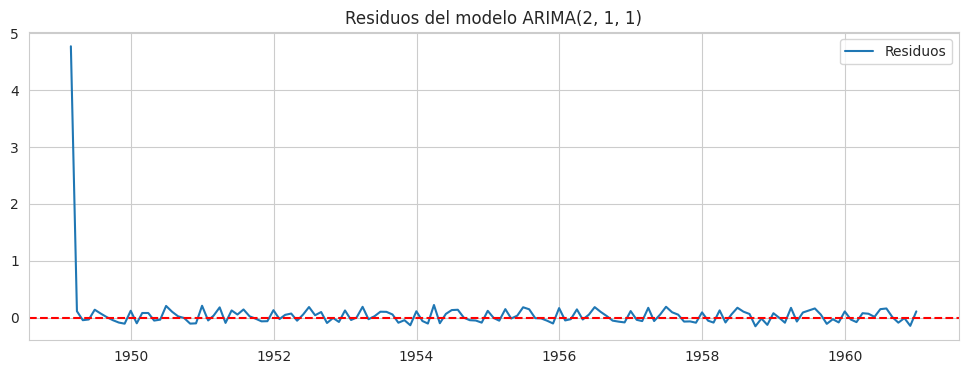

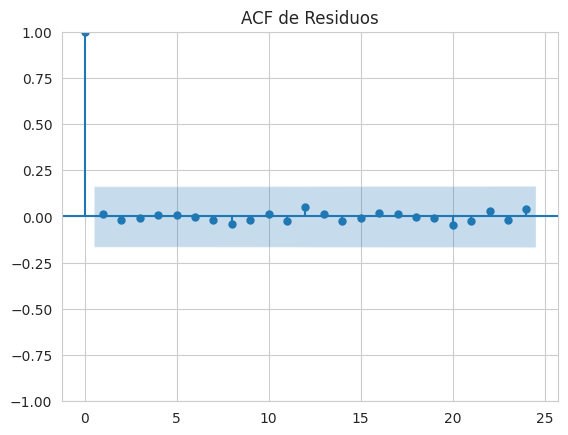

In [24]:
best_order = min(aic_values, key=aic_values.get)
print("Mejor modelo según AIC:", best_order)

best_model = ARIMA(endog_series, order=best_order).fit()
print(best_model.summary())

residuals = best_model.resid

plt.figure(figsize=(12,4))
plt.plot(residuals, label='Residuos')
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f"Residuos del modelo ARIMA{best_order}")
plt.legend()
plt.show()

# ACF de los residuos
plot_acf(residuals, lags=24, title="ACF de Residuos")
plt.show()

**Interpretación**:
- Queremos que no haya autocorrelaciones significativas en los residuos.  
- Si aún las hay, quizás debamos cambiar (p,q) o considerar estacionalidad (usando SARIMA).

---

## Sección 9: (Opcional) Pronóstico

Podemos pronosticar algunos meses del futuro y ver la evolución (en log y luego exponentiamos).


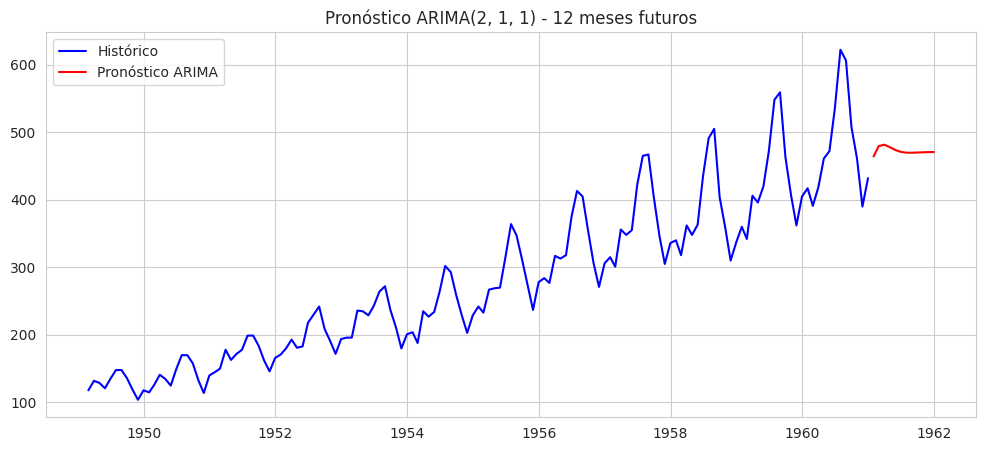

In [25]:
forecast_steps = 12  # pronosticar 1 año futuro
forecast_res = best_model.forecast(steps=forecast_steps)
# forecast_res estará en logscale (si entrenamos con LogPassengers)

df_forecast = pd.DataFrame({
    'Forecast_Log': forecast_res
})

# Creamos un rango de fechas continuo
last_date = df_air.index[-1]
future_dates = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=forecast_steps, freq='M')
df_forecast.index = future_dates

# Volvemos a escala normal
df_forecast['Forecast'] = np.exp(df_forecast['Forecast_Log'])

df_final = pd.concat([df_air[['AirPassengers']], df_forecast[['Forecast']]], axis=0)

plt.figure(figsize=(12,5))
plt.plot(df_final.index, df_final['AirPassengers'], label='Histórico', color='blue')
plt.plot(df_final.index, df_final['Forecast'], label='Pronóstico ARIMA', color='red')
plt.title(f"Pronóstico ARIMA{best_order} - 12 meses futuros")
plt.legend()
plt.show()


Idealmente, no deberían mostrar autocorrelaciones significativas.

---
## Sección 10: Validación (Breve Ejemplo de Forecast)

Haremos un split entreno-test para un periodo de tiempo y compararemos. 

In [27]:
train_size = int(len(df_air)*0.8)
train_data = df_air['AirPassengers'][:train_size]
test_data = df_air['AirPassengers'][train_size:]

p, d, q = 1, 1, 1
model2 = ARIMA(train_data, order=(p, d, q))
results2 = model2.fit()

start = test_data.index[0]
end = test_data.index[-1]

forecast = results2.predict(start=start, end=end, dynamic=False)


### Visualización


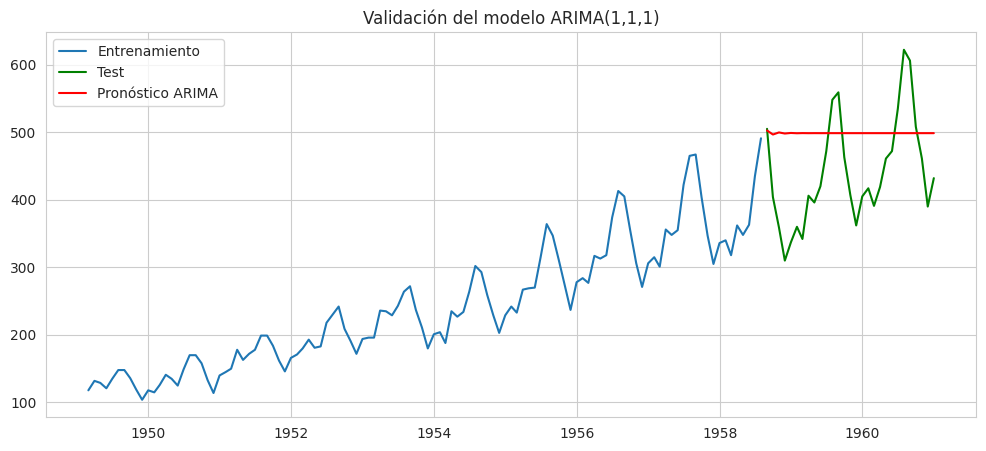

In [28]:
plt.figure(figsize=(12,5))
plt.plot(train_data.index, train_data, label='Entrenamiento')
plt.plot(test_data.index, test_data, label='Test', color='green')
plt.plot(forecast.index, forecast, label='Pronóstico ARIMA', color='red')
plt.legend()
plt.title(f"Validación del modelo ARIMA({p},{d},{q})")
plt.show()


**Discusión**:  
- Observamos la parte **pronosticada** en rojo.  
- En la práctica, compararíamos con valores reales posteriores (si existieran).

---

## Conclusión

1. **ARIMA** es efectivo en series univariadas con tendencia (y poca o manejable estacionalidad).  
2. Verificamos la **estacionariedad** mediante *d* (diferenciación) y test ADF.  
3. ACF/PACF orientan a p y q, junto con AIC/BIC para refinar la selección.  
4. Revisar los **residuos** para confirmar que no haya autocorrelaciones restantes.  
5. (Opcional) Realizar pronósticos y medir su rendimiento (MAPE, RMSE) en un conjunto test.

**Tarea**:  
- Aplicar este procedimiento (prueba de estacionariedad, ACF/PACF, ajuste ARIMA) a otro dataset real o a datos propios.  
- Ajustar diferentes (p,d,q) y comparar AIC/BIC.  
- Verificar los residuos y analizar la bondad del ajuste.

---

# Notas Finales

1. El **AirPassengers** es un **dataset estacional**. En realidad, se adapta mejor a un **SARIMA**. Sin embargo, para **ilustrar** ARIMA, sirve como demo.  
2. Si deseas un dataset no tan estacional, podrías usar [**Daily Minimum Temperatures in Melbourne**](https://www.kaggle.com/datasets/robervalt/daily-min-temperatures) (donde la estacionalidad anual existe, pero no tan fuerte como un dataset mensual con clara tendencia).  
3. Explora la **descomposición** (`seasonal_decompose`) si quieres mostrar la estacionalidad.  
4. Ajusta **ventanas de train/test** para simular un escenario real de forecasting y medir error en la sección test.

Con este **Notebook**, se tiene una **demo completa** de ARIMA con un dataset clásico, incluyendo:

- Verificación de estacionariedad  
- Diferenciación  
- ACF/PACF  
- Selección de (p,d,q) con AIC/BIC  
- Ajuste y análisis de residuos  
- Forecast y visualización final

Recomendaciones finales para la clase
Pausa para la práctica:
Dedica tiempo para que los alumnos prueben diferentes (p,d,q).
Muestra cómo interpretar la tabla con AIC/BIC y la ACF de los residuos.
Refuerzo teórico:
Si sobran unos minutos, menciona que SARIMA (Seasonal ARIMA) se usa para estacionalidad fuerte, y será tema de otra clase (o “Parte 2”).
Ejemplos reales:
Si tienes tiempo, demuestra un dataset real (por ejemplo, ventas diarias) para que los alumnos vean la utilidad en un caso real.
Documentación:
statsmodels: https://www.statsmodels.org/stable/tsa.html
pmdarima (Auto-ARIMA): https://github.com/alkaline-ml/pmdarima
Con este guion de presentación teórica y el notebook de ejemplo, tendrás un material completo para el Día 4 sobre ARIMA. ¡Éxitos en tu clase!